<a href="https://colab.research.google.com/github/sarisboo/tl_dr_abstractive/blob/master/transfomer_with_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Transformer Architecture 

Based on the 'Attention Is All You Need' paper, the transformer architecture significantly improved various natural language understanding related tasks by  using attention mechanisms. It also is much faster to train and easier to parrallelize.

## Transformer Components

**Encoder**: It takes as input a batch of sentences (as sequence of word ids), with input shape = [*batch size*, *max input sequence length*] and encodes each words as a 512 dimensional repesentation.
The encoder's output shape is then [*batch size, max input sentence length, 512*]. 

**Decoder**: While training, it takes target sentences as input (sequence of word ids). These sentences are shifted one time step to the right (inserting a start of sequence token at the beginning).
It receives the output of the encoder as well and outputs a probability for each possible next word at each time step (output shape = [*batch size, max output sentence length, vocabulary length*].
During inference, we cannot feed targets to the decoder, so we feed it the previously output words (we start with a start of sequence token). The model needs to be called repeatedly, predicting one or more words at every round which is in turn fed to the decoder at the next round until it outputs an end-of-sequence token.




# Transfer Learning

For our pilot project, we will leverage the power of transfer learning along with the transformer. For this, we use the `bert_en_uncased_L-12_H-768_A-12` model from tensorflow hub as the encoder.
This pre-trained model uses:

- 12 hidden layers (transformer blocks)
- A hidden size of 768
- 12 Attention Heads 

This model has been pre trained for english on Wikipedia and an extensive book corpus. Inputs have been uncased which means that text has been lower cased before WordPiece tokenization and any accent markers have been stripped away. Random input masking was applied independently to wordpieces.




#Package installations

In [0]:
!pip install bert-for-tf2

In [0]:
!pip install tensorflow-datasets

# Get the bert model from tensorflow hub

In [0]:
#!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip 

# Imports 

In [0]:

%tensorflow_version 2.x
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, load_stock_weights 
import os
import re
import time
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading the CNN_Dailymail dataset (supervised)

In [0]:
# Dataset I am not preprocessing 
examples, metadata = tfds.load('cnn_dailymail', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incompleteT6U9W0/cnn_dailymail-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incompleteT6U9W0/cnn_dailymail-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0.incompleteT6U9W0/cnn_dailymail-test.tfrecord


Dataset cnn_dailymail downloaded and prepared to /root/tensorflow_datasets/cnn_dailymail/plain_text/3.0.0. Subsequent calls will reuse this data.


In [0]:
metadata

tfds.core.DatasetInfo(
    name='cnn_dailymail',
    version=3.0.0,
    description='CNN/DailyMail non-anonymized summarization dataset.

There are two features:
  - article: text of news article, used as the document to be summarized
  - highlights: joined text of highlights with <s> and </s> around each
    highlight, which is the target summary
',
    homepage='https://github.com/abisee/cnn-dailymail',
    features=FeaturesDict({
        'article': Text(shape=(), dtype=tf.string),
        'highlights': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=311971,
    splits={
        'test': 11490,
        'train': 287113,
        'validation': 13368,
    },
    supervised_keys=('article', 'highlights'),
    citation="""@article{DBLP:journals/corr/SeeLM17,
      author    = {Abigail See and
                   Peter J. Liu and
                   Christopher D. Manning},
      title     = {Get To The Point: Summarization with Pointer-Generator Networks},
      journal   = {C

In [0]:
for article, highlights in val_examples.take(1):
  print(article)
  print(highlights)

tf.Tensor(b"Sally Forrest, an actress-dancer who graced the silver screen throughout the '40s and '50s in MGM musicals and films such as the 1956 noir While the City Sleeps died on March 15 at her home in Beverly Hills, California. Forrest, whose birth name was Katherine Feeney, was 86 and had long battled cancer. Her publicist, Judith Goffin, announced the news Thursday. Scroll down for video . Actress: Sally Forrest was in the 1951 Ida Lupino-directed film 'Hard, Fast and Beautiful' (left) and the 1956 Fritz Lang movie 'While the City Sleeps' A San Diego native, Forrest became a protege of Hollywood trailblazer Ida Lupino, who cast her in starring roles in films including the critical and commercial success Not Wanted, Never Fear and Hard, Fast and Beautiful. Some of Forrest's other film credits included Bannerline, Son of Sinbad, and Excuse My Dust, according to her iMDB\xc2\xa0page. The page also indicates Forrest was in multiple Climax! and Rawhide television episodes. Forrest app

# Preprocessing Steps 


## Build a subwords tokenizer from the training set for the decoder 

We create a custom subwords tokenizer from the training set for the decoder and store the vocabulary a vocab file for further faster access. 

In [0]:
'''
# First time creating a vocabulary file (takes a while)
# Then save it and access it with the script in the below cell

# Generate summary vocabulary from corpus
vocab_summary_file = 'vocab_summary_cnn_dm'
tokenizer_summary = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (highlights.numpy() for article, highlights in train_examples), target_vocab_size=2**13)
tokenizer_summary.save_to_file(vocab_summary_file)

# Example of encoded/decoded text
encoded = tokenizer_summary.encode("Mom goes to school")
decoded = tokenizer_summary.decode(encoded)
encoded
'''

'\n# First time creating a vocabulary file (takes a while)\n# Then save it and access it with the script in the below cell\n\n# Generate summary vocabulary from corpus\nvocab_summary_file = \'vocab_summary_cnn_dm\'\ntokenizer_summary = tfds.features.text.SubwordTextEncoder.build_from_corpus(\n    (highlights.numpy() for article, highlights in train_examples), target_vocab_size=2**13)\ntokenizer_summary.save_to_file(vocab_summary_file)\n\n# Example of encoded/decoded text\nencoded = tokenizer_summary.encode("Mom goes to school")\ndecoded = tokenizer_summary.decode(encoded)\nencoded\n'

In [0]:
#Faster way to access and add subwords to vocab
vocab_file = '/content/drive/My Drive/Colab Notebooks/data/cnn_dailymail/vocab_summary_cnn_dm'
if os.path.isfile(vocab_file + '.subwords'):
  tokenizer_summary = tfds.features.text.SubwordTextEncoder.load_from_file(vocab_file)
else: 
  tokenizer_summary = tfds.features.text.SubwordTextEncoder.build_from_corpus((highlights.numpy() for article, highlights in train_examples), target_vocab_size=2**13)
  tokenizer_summary.save_to_file('vocab_summary_cnn_dm')

# BERT 
Bert is a multi-layer bidirectional Transformer encoder. 

**Tokenization in BERT**: A start token `[CLS]` and a `[SEP]` token are inserted at the start and end of each sequence and these tokens are being encoded into ids that BERT understands.

To pre-train BERT, two unsupervised tasks are used. 

- **Masked LM**: Some percentage of the input tokens are randomy masked, then those masked tokens predicted. This procedure is referred to as Masked LM (MLM).To mitigate the mismatch between pre training and fine tuning the training data generator chooses 15% of the token positions at random for prediction. If, for instance the i-th token is chosen, it will be replaced with the `[MASK]` token 80% of the time, random token 10% of the time or the unchanged i-th token 10% of the time.

- **Next Sentence Prediction**: To train a model that understands sentence relationships, we pre train for a binarized *next sentence prediction*. When choosing the sentences A and B for each pre training example, 50% of the time B is the actual next sentence taht follows A and 50% of the time it is a random sentence from the corpus.

## Attention in BERT

In BERT, attention is a function that takes a sequence X where each element is a vector and returns a sequence Y of the same length. Each word can be associated with a word embedding (vector) that captures different attributes of that word. 
When we apply attention to a word embedding we create what is called a composite word embedding that help understand the relationships between words in a sentence.

- **Multi Head Attention** BERT actually learns multiple attention mechanisms called heads which work in a parallelized way. Repeated composition of word embeddings allows BERT to form richer representations as it goes into the deeper layers of the model. Attention heads do not share parameters. Each head learns a unique attention pattern, here we have 12 hidden layers x 12 heads = 144 attention mechanisms.

- **Attention Weights**: They are computed using a compatibility function which assigns a score to each pair of words indicating how important the attention should be between them. To compute the compatibility, the model assigns to each word a query vector and a key vector, then the compatibility score is computed by taking the dot product of the query vector of one word and the key vector of the other word.
The compatibility scores are then normalized to be positive and summing to 1 (since attention weights are used to compute weighted averages). For this , we use the softmax function over the scores of a given word.


## Use BERT Tokenization for the encoder

In [0]:
#Creating a Full Tokenizer class
BertTokenizer = bert.bert_tokenization.FullTokenizer
#Creating a non trainable BERT layer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=False) # trainable is set to False because we don't want to train the BERT embedding

In [0]:
#Creating a BERT vocabulary file as a numpy array
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
#Set the text to lowercase 
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
#Pass the vocabulary_file and to_lower_case variables to the BertTokenizer object
bert_tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [0]:
#Testing the BERT tokenizer 
sample_sentence = "Learning deep learning is hard but rewarding"
sample_tokens = bert_tokenizer.tokenize(sample_sentence)
#Converting tokens to ids 
sample_ids = bert_tokenizer.convert_tokens_to_ids(['[CLS]'] + sample_tokens + ['[SEP]'])
sample_sentence, sample_tokens, sample_ids

('Learning deep learning is hard but rewarding',
 ['learning', 'deep', 'learning', 'is', 'hard', 'but', 'reward', '##ing'],
 [101, 4083, 2784, 4083, 2003, 2524, 2021, 10377, 2075, 102])

## Tokenizing and encoding 
The `encode` function encodes articles and highlights in a way that bert and the decoder understand. For bert, `[CLS]` and `[SEP]` tokens are added to the beginning and end of the tokenized text to define start and end of sequences.

In [0]:
# Adding start and end tokens to input and target 

MAX_SEQ_LENGTH = 300 # Token length (i.e. words) changed from 510 

def encode(article, highlights, seq_length=MAX_SEQ_LENGTH):
    tokens_article = bert_tokenizer.tokenize(tf.compat.as_text(article.numpy()))
    articles = bert_tokenizer.convert_tokens_to_ids(['[CLS]'] + tokens_article + ['[SEP]'])
    if len(articles) < seq_length:
      articles = articles + list(np.zeros(seq_length - len(articles), 'int32'))
      
    summary = [tokenizer_summary.vocab_size] + tokenizer_summary.encode(
        tf.compat.as_text(highlights.numpy())) + [tokenizer_summary.vocab_size + 1]
    if len(summary) < seq_length:
      summary = summary + list(np.zeros(seq_length - len(summary), 'int32'))
      
    return articles, summary

In [0]:
def filter_max_length(x, y, max_length=MAX_SEQ_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [0]:
# Encode texts into integers 
train_dataset = train_examples.map(lambda article, highlights: tf.py_function(encode, [article, highlights], [tf.int32, tf.int32]))
train_dataset = train_dataset.filter(filter_max_length)

In [0]:
# Cache dataset to memory to get a faster reading 
BUFFER_SIZE = 50000
BATCH_SIZE = 64

train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1]), drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

In [0]:
# Do the same with the validation dataset
val_dataset = val_examples.map(lambda article, highlights: tf.py_function(encode, [article, highlights], [tf.int32, tf.int32]))
val_dataset = val_dataset.filter(filter_max_length)
val_dataset = val_dataset.padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1]))

# Positional encoding 

A positional embedding is a dense vector, it encodes the position of a word within a sentence.
We add the i-th  positional embedding to the word embedding of the i-th word in the sentence. Here we use fixed positional embeddings usng the sine and cosine functions of different frequencies. This solution was chosen because it can extend to arbitrarily long sentences.

After we add the positional embedding to the word embeddding , the model has access to the absolute position of each word in the sentence (unique positional embedding for each position). The sine and cosine functions are oscillating functions that allow the model to learn relative positions as well.

In [0]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

In [0]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    sines = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    cosines = np.cos(angle_rads[:, 1::2])

    pos_encoding = np.concatenate([sines, cosines], axis=-1)

    pos_encoding = pos_encoding[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

## Visualizing Positional Encoding

In [0]:
position = 10
d_mod = 512
angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_mod)[np.newaxis, :],
                            d_mod)

# apply sin to even indices in the array; 2i
sines = np.sin(angle_rads[:, 0::2])

# apply cos to odd indices in the array; 2i+1
cosines = np.cos(angle_rads[:, 1::2])
pos_encoding = np.concatenate([sines, cosines], axis=-1)


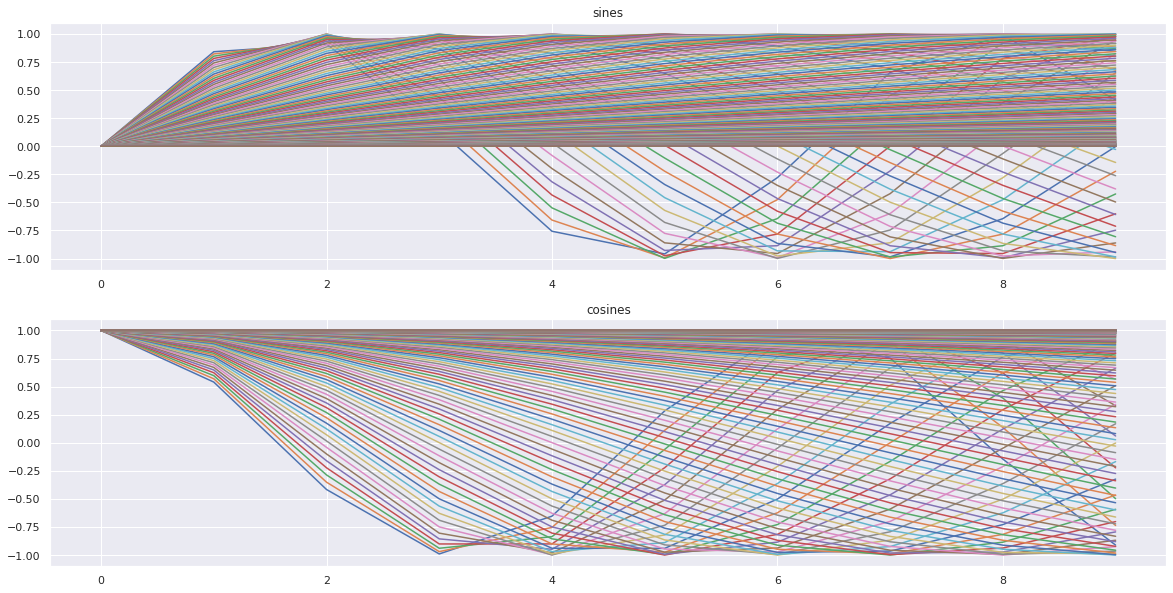

In [0]:
# Plotting sine and cosine vectors
fig, ax= plt.subplots(2, 1, figsize=(20, 10))

ax[0].plot(sines)
ax[0].set_title('sines')
ax[1].plot(cosines)
ax[1].set_title('cosines')
plt.show()

We use sine and cosine functions of different frequencies.
The sinusoidal version was chosen because it allows the model to extrapolate to sequence lengths longer than the ones encountered while training.



# Masking 

We mask to ensure that the model does not treat padding as the input. 
Where the pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.

In [0]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions so that we can add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [0]:
# Check padding mask
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

# Look-Ahead Mask

Masks the future tokens in a sequence (indicates which entries should not be used).

For instance, to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [0]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

# Scaled dot Product Attention 

The scaled dot product attention layer is the base of multi head attention. When the encoder analyzes an input sentence, for instance "He studied math", it manages to understand that "He" is the subject and the word "studied" is the verb so it encodes this information in the the representation of these words. 
If the decoder has already predicted the subject and thinks it has to predict the verb next, for this it needs to fetch the verb from the input sentence. 

It works like a dictionary lookup, as if the encoder created a dictionary and the decoder wanted to look up the value corresponding to the key "verb" but since the model has vectorized representations of the tokens (learned during training), the key that will be used for lookup (the query) will not perfectly match any key in the dictionnary.

So we compute a similarity scores between the query and each key in the dictionnary and then use the softmax function to convert these scores to weights that sum up to 1. The more similar the key to the query, the closer it will be to 1.

The model can then compute the weighted sum of the corresponding values. The similarity measure used by the Transformer is simply the dot product.

In the follwing function:

<center> Attention (Q, K, V) = softmax(Q$K^T$/$\sqrt{d_{keys}}$)V </center>

**Q**: Is a matrix that contains one row per query (shape = [n_queries, d_keys]), where n_queries is the number of queries and d_keys is the number of dimensions of each query and each key.

**K**: Is a matrix containing one row per key (shape=[n_keys, d_keys]), where n_keys is the number of keys and values.

**V**: Is a matrix containing one row per value (shape =[n_keys, d_values]), where d_values is the number of each value.

**Q $K^T$**: Is of shape [n_queries, n_keys] and contains one similarity score per query/key pair. The output of the softmax function has the same shape but all the rows sum up to 1. 

**Masking**: We can mask out some key-value pairs by adding a very large negative number, (in this case 1e-09) to the corresponding similarity scores, just before computing the softmax. Useful in the Masked Multi Head Attention layer.



In [0]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.
    
    Args:
      q: query shape == (..., seq_len_q, depth)
      k: key shape == (..., seq_len_k, depth)
      v: value shape == (..., seq_len_v, depth_v)
      mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.
      
    Returns:
      output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk: The scaling factor scales down the similarity scores to avoid saturating the softmax function (leads to tiny gradients)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

        # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

# Multi Head Attention layer 

The Multi Head Attention layer is a group of Scaled-Dot Product Attention layers each of them preceded by a linear transformation of the values, keys and queries (time-distributed Dense layer with no activation function).

We concatenate all the outputs and they go through a final layer transformation (Time distributed). 

The word representation encodes many different characteristics of the word. The Multi-Head Attention layer applies multiple different linear transformations of the values, keys and queries. It allows the model to apply many different projections of the word representation into different subspaces, each focuses on a subset of the word's charactristics.

So, for instance, maybe one of the linear layers will project the word representation into a subspace where all that remains is the information that the word is a verb, another linear layer will select the fact that it is past tense etc... Then the Scaled-Dot Product Attention layers apply the lookup phase and we concatenate all the results and send them back to the original space.  



In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention,
                                        perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [0]:
# Multi Head Attention output example
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 768))  # (batch_size, encoder_sequence, d_model)
q = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=q, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

# Point wise feed forward network 
It is composed of 2 dense layers, the first one uses ReLU activation function and the second one has no activation function.

We can describe it as two convolutions with kernel size 1.
The dimensionality of input and output is d_model = 512, and the inner-layer has dimensionality dff = 1024.

In [0]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

# Encoder
We use the pre trained BERT model as encoder (output shape is [batch_size, input_seq_len, d_model]). 

In [0]:
def build_encoder(config_file):
    with tf.io.gfile.GFile(config_file, "r") as reader:
        #Loading BERT configuration
        stock_params = StockBertConfig.from_json_string(reader.read())
        #Converts the original BERT or ALBERT config dictionary to a `BertModelLayer.Params` instance
        #Returns a `BertModelLayer.Params` instance
        bert_params = stock_params.to_bert_model_layer_params()

    return BertModelLayer.from_params(bert_params, name="bert")

# Decoder layer
The decoder layer is composed of the following sublayers:

* **Masked multi-head attention**: with look-ahead mask and padding mask.

* **Multi-head attention (with padding mask)**:
  - V (value) and K (key) receive the encoder output as inputs.
  - Q (query) receives the output from the masked multi-head attention sublayer.

* **Point wise feed forward networks**: Applied to each position separately and identically.

* **Dropout layers**: for regularization, we apply dropout to the output of each sublayer before adding it to the sublayer input and normalized.

Each sublayer has:

- **Residual Connection**: Also called skip connections, they allow gradients to flow through a network directly, without passing through non-linear activation functions (which, depending on the weights, are a cause of vanishing or exploding gradients).

- **Normalization layer**: It normalizes the activations of the previous layer for each given example.

Each sublayer output is of type LayerNorm(x + Sublayer(x)), the normalization is done on the last axis of d_model (512-dimensional encoded representation of each word)


In [0]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [0]:
# Decoder Layer output example
sample_decoder_layer = DecoderLayer(512, 8, 2048)
sample_encoder_output = tf.random.uniform((64, 128, 768))

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

# Decoder

The Decoder is composed of:

- **Output embedding**: `x` of shape `[batch_size, target_seq_len, d_model]`
- **Positional Encoding**: Encoding the absolute and relative position of each word.
- **N decoder layers**: The decoder layers are stacked N times. We note that the encoder stack's final outputs are fed to the decoder at each of these N levels.

The target goes through an embedding that we sum to the positional encoding and feed the sum's output to the decoder layers. Finally, the output of the decoder is the input of the last linear layer.

We also apply dropout to the sums of the embeddings and the positional encodings for regularization. Here we use a dropout `rate` of `0.1`

In [0]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(target_vocab_size, self.d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        #For Regularization
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                   look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

# Creating the Transformer

We create a `Config` class to hold the hyperparameters.

Then we assemble all the parts above to create the Transformer initializing the following variables: 

- `self.encoder.trainable`: We use the previously built `build_encoder` function to load the bert model and make it trainable.

- `self.decoder`: We use the previously built `Decoder` class and the `Config` class to establish the number of layers`config.num_layers`, the the size of the encoded representation of each word `config.d_model`, dimension of the point-wise feed forward network `config.dff`, the `target_vocab_size` and the learning `rate`.

- `self.final_layer`: We then initialize a `final_layer` variable which consists in a `Dense` layer with the desired `target_vocab_size`. 

We then define the `load_stock_weights` function to load bert's stock weights and check if a training checkpoint already exists.

We use the `call` function to set up the encoder and the decoder for training but the decoder's output still has to go through the `final.layer` to produce a final output of shape `[batch_size, tar_seq_len, target_vocab_size]`.


In [0]:
class Config(object):
  def __init__(self, num_layers, d_model, dff, num_heads):
    self.num_layers = num_layers
    self.d_model = d_model
    self.dff = dff
    self.num_heads = num_heads

In [0]:
from bert.loader import map_to_stock_variable_name
class Transformer(tf.keras.Model):
  def __init__(self, config,
               target_vocab_size, 
               bert_config_file,
               bert_training=False, 
               rate=0.1,
               name='transformer'):
      super(Transformer, self).__init__(name=name)

      self.encoder = build_encoder(config_file=bert_config_file)
      self.encoder.trainable = bert_training

      self.decoder = Decoder(config.num_layers, config.d_model, 
                             config.num_heads, config.dff, target_vocab_size, rate)

      self.final_layer = tf.keras.layers.Dense(target_vocab_size)


  def load_stock_weights(self, bert: BertModelLayer, ckpt_file):
      assert isinstance(bert, BertModelLayer), "Expecting a BertModelLayer instance as first argument"
      assert tf.compat.v1.train.checkpoint_exists(ckpt_file), "Checkpoint does not exist: {}".format(ckpt_file)
      ckpt_reader = tf.train.load_checkpoint(ckpt_file)

      bert_prefix = 'transformer/bert'

      weights = []
      for weight in bert.weights:
          stock_name = map_to_stock_variable_name(weight.name, bert_prefix)
          if ckpt_reader.has_tensor(stock_name):
              value = ckpt_reader.get_tensor(stock_name)
              weights.append(value)
          else:
              raise ValueError("No value for:[{}], i.e.:[{}] in:[{}]".format(
                  weight.name, stock_name, ckpt_file))
      bert.set_weights(weights)
      print("Done loading {} BERT weights from: {} into {} (prefix:{})".format(
          len(weights), ckpt_file, bert, bert_prefix))

  def restore_encoder(self, bert_ckpt_file):
      # loading the original pre-trained weights into the BERT layer:
      self.load_stock_weights(self.encoder, bert_ckpt_file)

  def call(self, inp, tar, training, look_ahead_mask, dec_padding_mask):
      enc_output = self.encoder(inp, training=self.encoder.trainable)  # (batch_size, inp_seq_len, d_model)

      # dec_output.shape == (batch_size, tar_seq_len, d_model)
      dec_output, attention_weights = self.decoder(
          tar, enc_output, training, look_ahead_mask, dec_padding_mask)

      final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

      return final_output, attention_weights

# Hyperparameters
We set the following hyperparameters to keep this example small and relatively fast.

In [0]:
target_vocab_size = tokenizer_summary.vocab_size + 2
dropout_rate = 0.1
config = Config(num_layers=6, d_model=256, dff=1024, num_heads=8)

# Building the Transformer and Checkpointing

In [0]:
MODEL_DIR = "/content/drive/My Drive/Colab Notebooks/pre_trained_models/BERT/uncased_L-12_H-768_A-12" 
bert_config_file = os.path.join(MODEL_DIR, "bert_config.json")
bert_ckpt_file = os.path.join(MODEL_DIR, "bert_model.ckpt")

transformer = Transformer(config=config,
                          target_vocab_size=target_vocab_size,
                          bert_config_file=bert_config_file)
  
inp = tf.random.uniform((BATCH_SIZE, MAX_SEQ_LENGTH))
tar_inp = tf.random.uniform((BATCH_SIZE, MAX_SEQ_LENGTH))
fn_out, _ = transformer(inp, tar_inp, 
                        True,
                        look_ahead_mask=None,
                        dec_padding_mask=None)
print(tar_inp.shape) # (batch_size, tar_seq_len) 
print(fn_out.shape)  # (batch_size, tar_seq_len, target_vocab_size) 

# init bert pre-trained weights
transformer.restore_encoder(bert_ckpt_file)

(64, 300)
(64, 300, 8115)
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


Done loading 196 BERT weights from: /content/drive/My Drive/Colab Notebooks/pre_trained_models/BERT/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f5c13644eb8> (prefix:transformer/bert)


In [0]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BertModelLayer)        multiple                  108890112 
_________________________________________________________________
decoder (Decoder)            multiple                  9970944   
_________________________________________________________________
dense_74 (Dense)             multiple                  2085555   
Total params: 120,946,611
Trainable params: 12,056,499
Non-trainable params: 108,890,112
_________________________________________________________________


# Optimizer 

Use the Adam optimizer with a custom learning rate scheduler.


In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [0]:
learning_rate = CustomSchedule(config.d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

## Plotting the Learning Rate Schedule Vs. Training Steps 

Text(0.5, 0, 'Train Step')

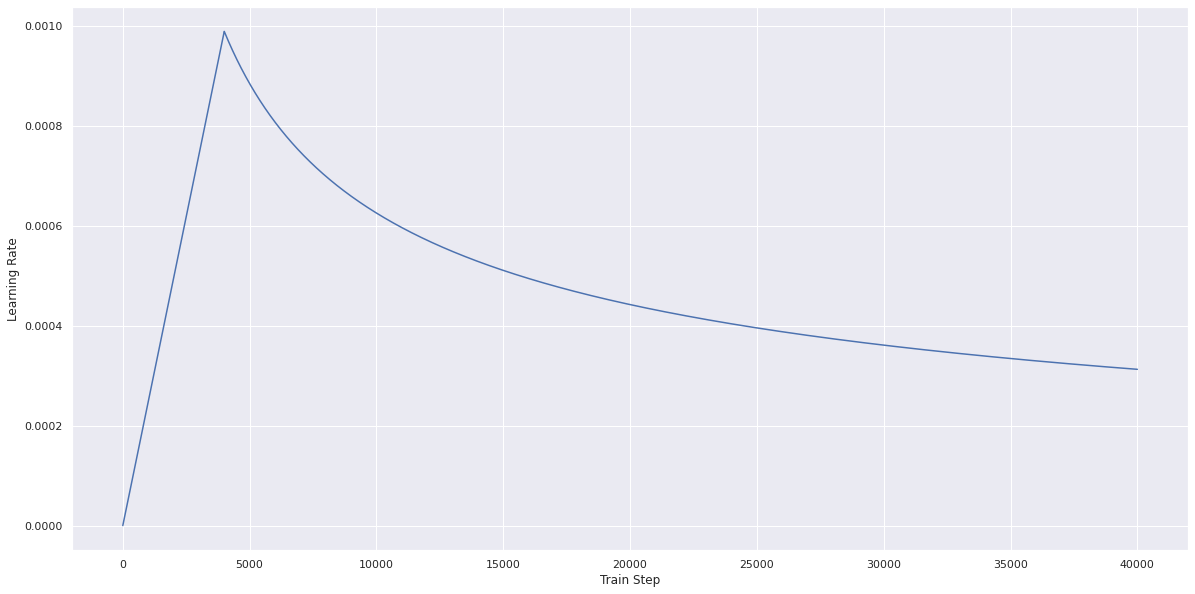

In [0]:
temp_learning_rate_schedule = CustomSchedule(config.d_model)
plt.figure(figsize=(20,10))
plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

The custom optimizer `CustomSchedule` consists in increasing the learning rate linearly for the first 'warm-up' training steps, then decreasing it proportinally to the inverse square root of the step number. In our example, there are 4000 warmup steps. 

# Loss and Metrics

We apply a padding mask while calculating the loss because the target sequences were padded.

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [0]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

### Training and checkpointing

Create the checkpoint path and the checkpoint manager (for saving checkpoints every n epochs).

In [0]:
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/train_bert_cnn_dm_v1"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

Latest checkpoint restored!!


## Teacher Forcing

Teacher Forcing gives the model training a boost by replacing each sequence prediction at each time step with the actual correct sequence at that time step. So, rather than using a prediction for a sequence at time t, we would use the actual value from the training set.

Self-attention gives the transformer the opportunity to look at the input sequence so far (previous words) so it can more accurately predict the next word (preventing leftward information flow in the decoder to preserve the auto-regressive property)

The `create-masks` function lets us create a padding mask for the decoder as well as a look ahead mask. The look ahead mask forbids the model from looking at the expected output. To implement this inside of scaled dot-product attention we mask out (setting to a big negative number) all values in the input of the softmax which correspond to illegal connections.


In [0]:
def create_masks(inp, tar):
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return combined_mask, dec_padding_mask

# Training

We define the `train_step` function to train our data at a specific step during which we make `predictions`, compute the `train_loss` and `train_accuracy`. We use the `tf.GradientTape()` context manager for automatic differentiation (calculating the gradient of a computation with respect to its input variables).

Finally, we compile this function as a callable TensorFlow Graph by wrapping it within the `@tf.function()` decorator.  

In [0]:
@tf.function()
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True,
                                     combined_mask,
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

## Training loop and saving weights

In this example, the data was trained during 20 epochs and, due to colab limitations, over several days and properly checkpointed. To get a better accuracy, more training epochs are needed and over more batches (more training data). The hyperparameters were kept simple and training data was kept minimal due to colab TPU limitations.

Every 5 batches we print the `accuracy`, `loss` and total `time` spent training 1 epoch and thus can monitor the training progress. We save the training checkpoint after every epoch and when training is finalized we save the final weights of the transformer.

`inp` = articles 

`tar` = summaries

In [0]:
EPOCHS = 1 # Actually trained over 20 epochs but for colab limitation reasons this was done over several days and properly checkpointed

for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> article , tar -> summary
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 5 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 1 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))
                                                         
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, train_loss.result(), train_accuracy.result()))
                                                

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

transformer.save_weights('/content/drive/My Drive/Colab Notebooks/saved_weights/bert_cnn_dm_v2/bert_sum_ckpt')

Epoch 1 Batch 0 Loss 0.4251 Accuracy 0.1096
Epoch 1 Batch 5 Loss 0.4129 Accuracy 0.1144
Epoch 1 Batch 10 Loss 0.4146 Accuracy 0.1135
Epoch 1 Batch 15 Loss 0.4135 Accuracy 0.1125
Epoch 1 Batch 20 Loss 0.4134 Accuracy 0.1124
Epoch 1 Batch 25 Loss 0.4136 Accuracy 0.1124
Epoch 1 Batch 30 Loss 0.4148 Accuracy 0.1119
Epoch 1 Batch 35 Loss 0.4171 Accuracy 0.1116
Epoch 1 Batch 40 Loss 0.4175 Accuracy 0.1113
Epoch 1 Batch 45 Loss 0.4207 Accuracy 0.1114
Epoch 1 Batch 50 Loss 0.4229 Accuracy 0.1118
Epoch 1 Batch 55 Loss 0.4253 Accuracy 0.1116
Epoch 1 Batch 60 Loss 0.4267 Accuracy 0.1112
Epoch 1 Batch 65 Loss 0.4287 Accuracy 0.1110
Epoch 1 Batch 70 Loss 0.4292 Accuracy 0.1109
Epoch 1 Batch 75 Loss 0.4302 Accuracy 0.1106
Epoch 1 Batch 80 Loss 0.4317 Accuracy 0.1103
Epoch 1 Batch 85 Loss 0.4340 Accuracy 0.1101
Epoch 1 Batch 90 Loss 0.4351 Accuracy 0.1100
Epoch 1 Batch 95 Loss 0.4368 Accuracy 0.1099
Epoch 1 Batch 100 Loss 0.4371 Accuracy 0.1095
Epoch 1 Batch 105 Loss 0.4387 Accuracy 0.1092
Epoch 1 Ba

# Evaluation and Summarization 

We create the `encode_article` function that encodes new input text in a way bert understands by using `bert_tokenizer`. It adds start and end tokens so the shape of the model is the same as the one it was trained on.

In [0]:
def encode_article(article):
    tokens_article = bert_tokenizer.tokenize(article)
    article = bert_tokenizer.convert_tokens_to_ids(['[CLS]'] + tokens_article + ['[SEP]'])

    return article

In [0]:
sentence_ids = encode_article("In 2006, the idea that an unknown virus might spill out of some wild animal into humans, achieving person-to-person transmission and causing a global pandemic, seemed a distant prospect to most people. As an engaging science-fiction scare, it ranked somewhere beneath “Alien: Resurrection.” But Ali S. Khan, of the National Center for Zoonotic, Vector-Borne, and Enteric Diseases, was tasked with dreaming that nightmare by daylight. nczved (pronounced “N. C. Zved,” according to Khan), part of the Centers for Disease Control and Prevention, resided in an unobtrusive gray brick building, behind locked gates and locked doors in the C.D.C.’s compound on Clifton Road, six miles northeast of downtown Atlanta. During a two-day visit that year, I worked my way along the nczved corridors, interviewing scientists who knew all about Ebola viruses (yes, there are more than one) and their lethal cousin Marburg; about West Nile virus in the Bronx and Sin Nombre virus in Arizona; about simian foamy virus in Bali, which is carried by temple monkeys that crawl over tourists, and monkeypox, which reached Illinois in giant Gambian rats sold as pets; about Junin virus in Argentina and Machupo virus in Bolivia; about Lassa virus in West Africa, Nipah virus in Malaysia, Hendra virus in Australia, and rabies everywhere. All these viruses are zoonotic, meaning that they can pass from animals to people. Most of them, once in a human body, cause mayhem. Some of them also transmit well among people, bursting into local outbreaks that may kill hundreds. They are new to science and to human immune systems; they emerge unpredictably and are difficult to treat; and they can be especially dangerous, as reflected in the name of the branch within nczved that studied them—Special Pathogens. For these reasons, some scientists and public-health experts, including Ali Khan, find the viruses an irresistible challenge. 'It’s because they keep you on your toes,'he told me. On the second day of my visit, amid the intriguingly gruesome briefings, Khan took me out for sushi.")
print(bert_tokenizer.convert_ids_to_tokens(sentence_ids))

['[CLS]', 'in', '2006', ',', 'the', 'idea', 'that', 'an', 'unknown', 'virus', 'might', 'spill', 'out', 'of', 'some', 'wild', 'animal', 'into', 'humans', ',', 'achieving', 'person', '-', 'to', '-', 'person', 'transmission', 'and', 'causing', 'a', 'global', 'pan', '##de', '##mic', ',', 'seemed', 'a', 'distant', 'prospect', 'to', 'most', 'people', '.', 'as', 'an', 'engaging', 'science', '-', 'fiction', 'scare', ',', 'it', 'ranked', 'somewhere', 'beneath', '“', 'alien', ':', 'resurrection', '.', '”', 'but', 'ali', 's', '.', 'khan', ',', 'of', 'the', 'national', 'center', 'for', 'zoo', '##not', '##ic', ',', 'vector', '-', 'borne', ',', 'and', 'enter', '##ic', 'diseases', ',', 'was', 'tasked', 'with', 'dreaming', 'that', 'nightmare', 'by', 'daylight', '.', 'nc', '##z', '##ved', '(', 'pronounced', '“', 'n', '.', 'c', '.', 'z', '##ved', ',', '”', 'according', 'to', 'khan', ')', ',', 'part', 'of', 'the', 'centers', 'for', 'disease', 'control', 'and', 'prevention', ',', 'resided', 'in', 'an', 'u

To evaluate our model, we write an `evaluate` function where:
 
* We use the `encode_article` function to properly encode the input. Then we properly pad it to the right size.

* We compute the combined masks and the decoder padding mask for the input text using the `create_masks` function.

* We then use the trained `transformer` to output the predictions and the attention weights, the transformer `decoder` outputs the predictions after looking at the `encoder`'s output and using the self-attention mechanism.

* We compute the argmax of the selected last word.

* We pass the concatenated predicted word to the `decoder`.

The `decoder` predicts the next word based on the previously predicted words.

In [0]:
def evaluate(transformer, inp_text):
    # normalize input sentence
    inp_text = encode_article(inp_text)
    encoder_input = tf.expand_dims(inp_text, 0)

    # as the target is the summary , the first word to the transformer should be the
    # summary start token.
    decoder_input = [tokenizer_summary.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_SEQ_LENGTH):
        combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input,
                                                     output,
                                                     False,
                                                     combined_mask,
                                                     dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, tokenizer_summary.vocab_size + 1):
            return tf.squeeze(output, axis=0), attention_weights

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

## Summarization

We use the previously defined `evaluate` function inside the `summarize` function to obtain the predictions and the attention weights.
To obtain the predicted summary, we use the `decode()` method of the previously defined `tokenizer_summary` instance, we also add a `plot` argument to the function to plot the attention weights of a given block inside a given layer by indicating which ones we want to plot.

In [0]:
def summarize(transformer, text, plot=''):
    result, attention_weights = evaluate(transformer, text)

    predicted_text = tokenizer_summary.decode([i for i in result
                                              if i < tokenizer_summary.vocab_size])

    print('Input: {}'.format(text))
    print('Predicted summary: {}'.format(predicted_text))

    if plot:
        plot_attention_weights(attention_weights, text, result, plot)

In [0]:
#summarize(transformer, "People in NASA build a new ventilator. NASA builds the ventilator in 37 days. The ventilator helps people with the coronavirus. The ventilator is different. It is less complicated than usual ventilators. It has fewer parts. It is not difficult to buy the parts. Medical workers can work with the ventilator more easily. The ventilator can work for three or four months. It is good only for people with the coronavirus. They do not need more complicated ventilators. It is possible to change some parts of the ventilator. Field hospitals can use it in emergency situations. NASA´s workers are happy. They help medical workers and hospitals.")

In [0]:
article_example = "A study carried out by Washington State University asked 122 men and women to take a maths test and then guess how well they had done. The guinea pig men and women were then told their scores and asked to take another test. After the second test, there was no information offered about how they had done, but they were asked to guess their results instead. It turned out that men consistently thought they had done better than they actually had. The women’s estimations, on the other hand, were right on the money. Although the sample was quite small, researchers say that gender gaps in areas like science, engineering, and maths may be the result of men thinking too highly of their performance. The report also shows the potential need for positive illusions." 

To reuse the trained model, we initialize the Transformer class with our preferred configurations and then load the saved weights of our trained model using the `load_weights()` method.

We then can pass the transfomer instance and input text arguments to teh `summarize` function.

In [0]:
# Use the translate func here after loading the weights 

new_transformer = Transformer(config=config,
                          target_vocab_size=target_vocab_size,
                          bert_config_file=bert_config_file)
  
fn_out, _ = new_transformer(inp, tar_inp, 
                        True,
                        look_ahead_mask=None,
                        dec_padding_mask=None)
new_transformer.load_weights('/content/drive/My Drive/Colab Notebooks/saved_weights/bert_cnn_dm_v2/bert_sum_ckpt')

summarize(new_transformer,article_example)

Input: A study carried out by Washington State University asked 122 men and women to take a maths test and then guess how well they had done. The guinea pig men and women were then told their scores and asked to take another test. After the second test, there was no information offered about how they had done, but they were asked to guess their results instead. It turned out that men consistently thought they had done better than they actually had. The women’s estimations, on the other hand, were right on the money. Although the sample was quite small, researchers say that gender gaps in areas like science, engineering, and maths may be the result of men thinking too highly of their performance. The report also shows the potential need for positive illusions.
Predicted summary: Students for a Christian State University said they had no questions it found .
They were the second test of the most prefers like their performance had done to found .
The Transfertion says the lowest was the l

## Plotting Attention Weights
we use the `plot_attention_weights` function to create heatmaps of attention, we can pass in different layers and attention blocks of the decoder to the plot parameter

In [0]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(50, 20))

    sentence_ids = encode_article(sentence)

    attention = tf.squeeze(attention[layer], axis=0)

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head + 1)

        # plot the attention weights
        cax = ax.matshow(attention[head][:-1, :], cmap='viridis')

        fig.colorbar(cax, shrink = 0.50)

        fontdict = {'fontsize': 10, 'family' : 'DFKai-SB'}

        ax.set_xticks(range(len(sentence_ids)))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result) - 1.5, -0.5)

        ax.set_xticklabels(
            bert_tokenizer.convert_ids_to_tokens(sentence_ids),
            fontdict=fontdict, rotation=90)

        ax.set_yticklabels([tokenizer_summary.decode([i]) for i in result
                            if i < tokenizer_summary.vocab_size],
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head + 1))
        

        
    plt.tight_layout()
    plt.show()

In [0]:
article_example_2 = "A study carried out by Washington State University asked 122 men and women to take a maths test and then guess how well they had done. The guinea pig men and women were then told their scores and asked to take another test. After the second test, there was no information offered about how they had done, but they were asked to guess their results instead. "

We can plot the attention weights and see which parts of the text the model is focusing on in a given time in a given layer in a particular attention block. Here, for example, we can see that for various heads, the model will focus on a specific group of words. Many of the following attention heads here are linking the words 'state', 'and 'university' with 'Washington', they focus on the relationship between this group of words to extract that the text is about a university in Washington. Other heads link the word 'women' with the word 'study' and 'asked' was associated by the group of words 'was' 'carried' 'out'. This show the model's potential for focusing on specific areas of text, 'understanding' them and finally outputting its own 'interpretation' of the input.

Input: A study carried out by Washington State University asked 122 men and women to take a maths test and then guess how well they had done. The guinea pig men and women were then told their scores and asked to take another test. After the second test, there was no information offered about how they had done, but they were asked to guess their results instead. 
Predicted summary: The study was carried out for a second test danced in the University of Washington .
It was the second pointing a poll to vote their performance dance .
It was no other points for the second points .


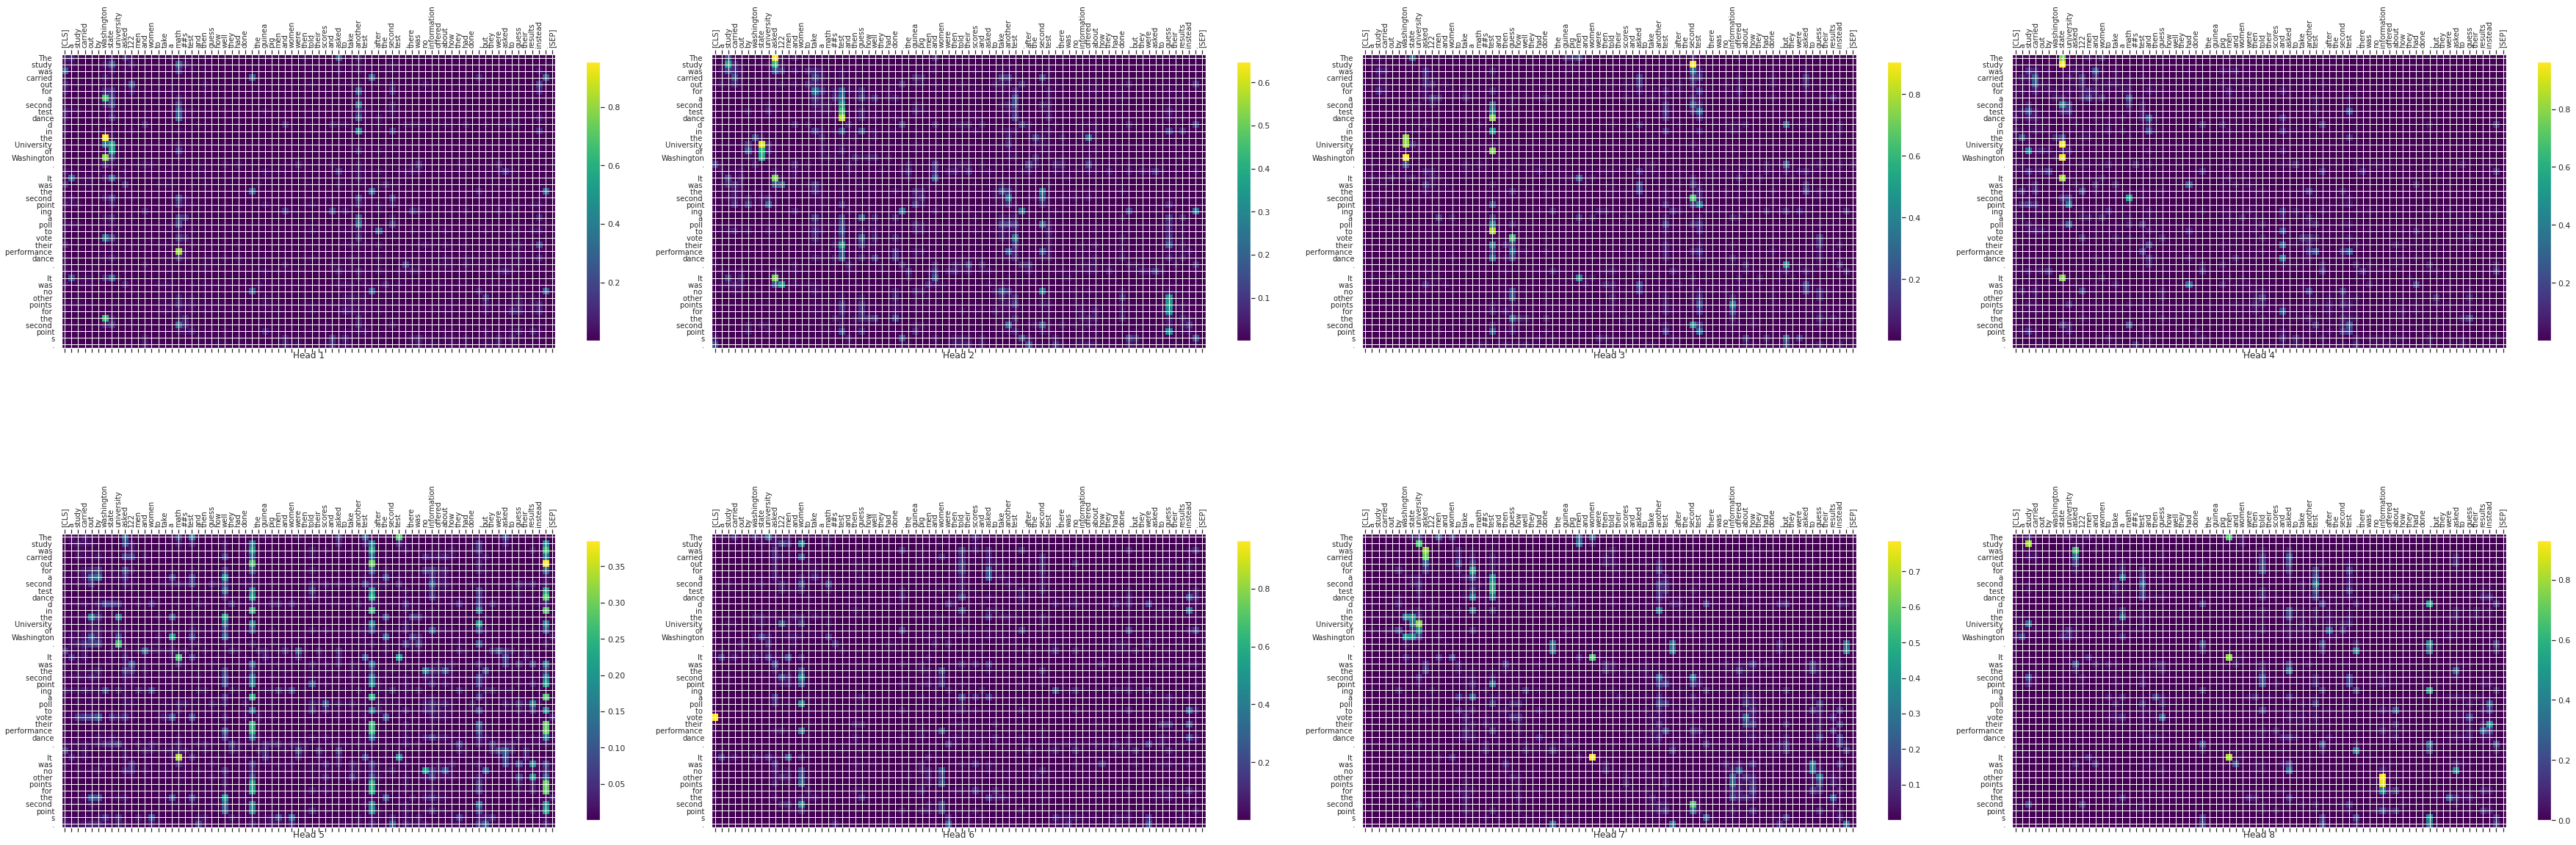

In [0]:
  summarize(new_transformer,article_example_2, plot ='decoder_layer5_block2')

Input: A study carried out by Washington State University asked 122 men and women to take a maths test and then guess how well they had done. The guinea pig men and women were then told their scores and asked to take another test. After the second test, there was no information offered about how they had done, but they were asked to guess their results instead. 
Predicted summary: The study was carried out for a second test danced in the University of Washington .
It was the second pointing a poll to vote their performance dance .
It was no other points for the second points .


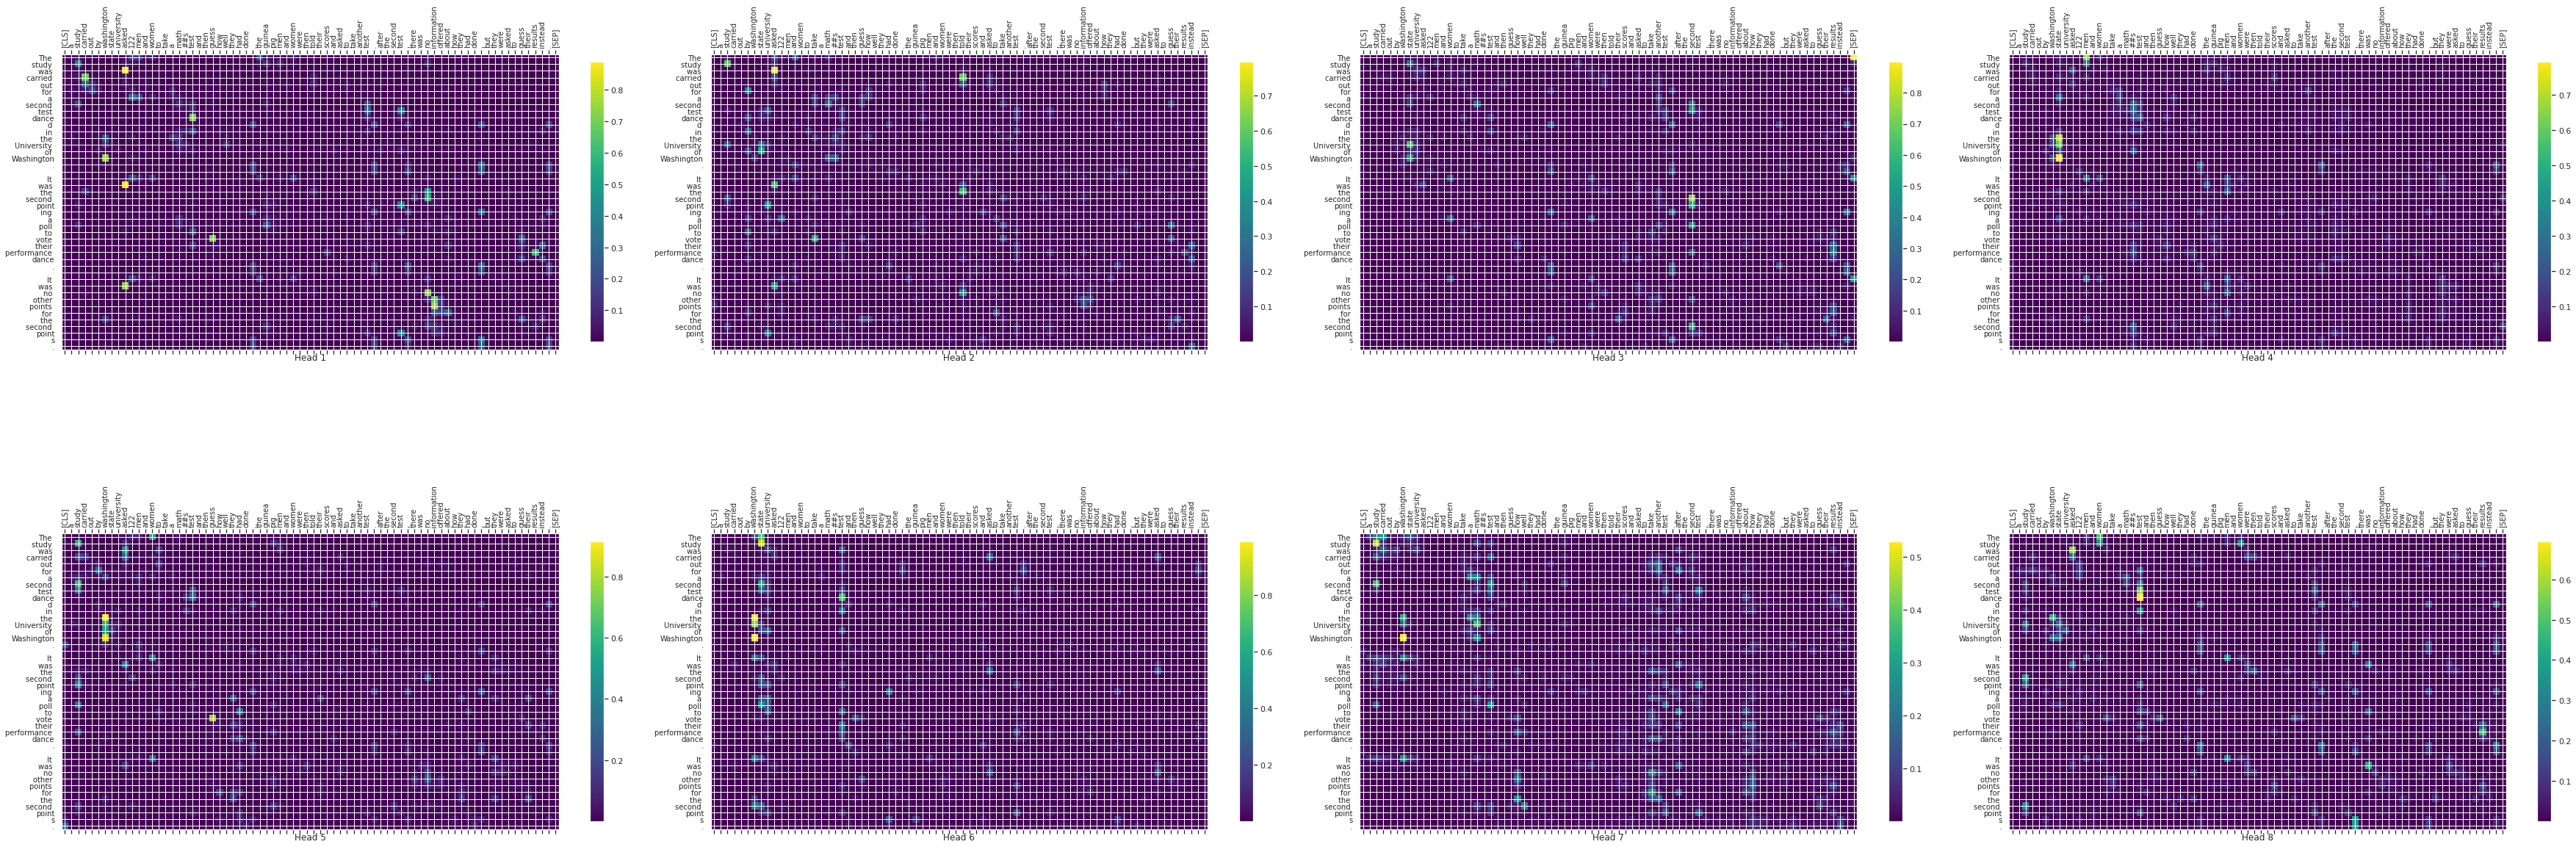

In [0]:
  summarize(new_transformer,article_example_2, plot ='decoder_layer6_block2')